#EDA

## Введение

**Хакатон Лента х Я.Практикум**

Получена задача построения модели предсказывающей продажи собственных продуктов Ленты на 2 недели.

Переданы исторические данные за год.

**Перед обучением модели необходимо провести exploratory data analysis.**

План.
1. Загрузить данные.
2. Изучить загруженные данные.
3. Проверить и предобработать данные.
4. Провести анализ данных
    * По данным магазинов;
    * Под данным продуктов;
    * По данным продаж.
5. Написать выводы о проделанной работе.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import (adfuller,
                                       kpss)

from scipy.stats import zscore

In [3]:
pd.options.display.float_format = '{:.3f}'.format

plt.rcParams['figure.figsize'] = (10, 5)

## Выгрузка данных

<b><font size="4">Описание данных.</font></b>

**sales_df_train.csv** – данные по продажам за скользящий год для обучения.

* st_id – захэшированное id магазина;
* pr_sku_id – захэшированное id товара;
* date – дата;
* pr_sales_type_id – флаг наличия промо;
* pr_sales_in_units – число проданных товаров без признака промо;
* pr_promo_sales_in_units – число проданных товаров с признаком промо;
* pr_sales_in_rub – продажи без признака промо в руб;
* pr_promo_sales_in_rub – продажи с признаком промо в руб.

**pr_df.csv** – данные по товарной иерархии.

От большего к меньшему pr_group_id - pr_cat_id - pr_subcat_id - pr_sku_id.

* pr_group_id – захэшированная группа товара;
* pr_cat_id – захэшированная категория товара;
* pr_subcat_id – захэшированная подкатегория товара;
* pr_sku_id – захэшированное id товара;
* pr_uom_id – маркер, обозначающий продаётся товар на вес или в шт.

**pr_st.csv** – данные по магазинам.

* st_id – захэшированное id магазина;
* st_city_id – захэшированное id города;
* st_division_code id – захэшированное id дивизиона;
* st_type_format_id – id формата магазина;
* st_type_loc_id – id тип локации/окружения магазина;
* st_type_size_id – id типа размера магазина;
* st_is_active – флаг активного магазина на данный момент.

**sales_submission.csv** – пример файла с результатом работы модели прогноза спроса.

Необходимо подготовить файл в таком же формате, заполнив колонку target предсказаниями (по умолчанию колонка заполнена нулями).

* st_id – захэшированное id магазина;
* pr_sku_id – захэшированное id товара;
* date – дата (день);
* target – спрос в шт.

In [4]:
df_pr = pd.read_csv('/content/drive/MyDrive/hackathon_lenta/pr_df.csv')
df_sales = pd.read_csv('/content/drive/MyDrive/hackathon_lenta/sales_df_train.csv')
df_submissions = pd.read_csv('/content/drive/MyDrive/hackathon_lenta/sales_submission.csv')
df_st = pd.read_csv('/content/drive/MyDrive/hackathon_lenta/st_df.csv')

In [5]:
df_pr_original = df_pr.copy()
df_sales_original = df_sales.copy()
df_submissions_original = df_submissions.copy()
df_st_original = df_st.copy()

In [6]:
df_pr.head()

,pr_sku_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
0,fd064933250b0bfe4f926b867b0a5ec8,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,17
1,71c9661741caf40a92a32d1cc8206c04,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17
2,00b72c2f01a1512cbb1d3f33319bac93,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,d407a3ebb4ab9b0d68b224486f8b8dad,17
3,9bc40cd2fe4f188f402bb41548c5e15c,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,17
4,3a74a370c8eb032acb11ad9119242b8f,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17


In [7]:
df_sales.head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.000,5.000,825.000,825.000
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.000,0.000,196.000,0.000
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.000,0.000,78.000,0.000
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.000,0.000,69.000,69.000
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.000,0.000,161.000,0.000


In [8]:
df_submissions.head()

,st_id,pr_sku_id,date,target
0,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-20,0
1,16a5cdae362b8d27a1d8f8c7b78b4330,00661699f543753ec7e911a64b9fd2f6,2023-07-20,0
2,16a5cdae362b8d27a1d8f8c7b78b4330,0094042bfeae507dc7f62acc8e5ed03a,2023-07-20,0
3,16a5cdae362b8d27a1d8f8c7b78b4330,0169529ff660adcac9b7e354e0c4b882,2023-07-20,0
4,16a5cdae362b8d27a1d8f8c7b78b4330,01e4734745e97e52d3213449e1a05dd7,2023-07-20,0


In [9]:
df_st

,st_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
0,1aa057313c28fa4a40c5bc084b11d276,1587965fb4d4b5afe8428a4a024feb0d,81b4dd343f5880df806d4c5d4a846c64,4,3,19,0
1,bd470ca955d9497bbcb808e59952fffc,955d864a62659945cc9434898e275deb,e26072c92d8fe0738df44d571d5f5e8b,4,3,19,1
2,6364d3f0f495b6ab9dcf8d3b5c6e0b01,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
3,1ecfb463472ec9115b10c292ef8bc986,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,2,1,28,1
4,16a5cdae362b8d27a1d8f8c7b78b4330,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1
5,53e19f3dbb211f20b20b45668303c1b6,955d864a62659945cc9434898e275deb,e26072c92d8fe0738df44d571d5f5e8b,4,3,20,1
6,42a0e188f5033bc65bf8d78622277c4e,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
7,c81e728d9d4c2f636f067f89cc14862c,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1
8,fa7cdfad1a5aaf8370ebeda47a1ff1c3,885fe656777008c335ac96072a45be15,296bd0cc6e735f9d7488ebc8fbc19130,1,1,12,1
9,f7e6c85504ce6e82442c770f7c8606f0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,1,1,12,1


## Предработка данных

### Датафрейм магазинов

* st_id – захэшированное id магазина;
* st_city_id – захэшированное id города;
* st_division_code id – захэшированное id дивизиона;
* st_type_format_id – id формата магазина;
* st_type_loc_id – id тип локации/окружения магазина;
* st_type_size_id – id типа размера магазина;
* st_is_active – флаг активного магазина на данный момент.

In [10]:
df_st

,st_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
0,1aa057313c28fa4a40c5bc084b11d276,1587965fb4d4b5afe8428a4a024feb0d,81b4dd343f5880df806d4c5d4a846c64,4,3,19,0
1,bd470ca955d9497bbcb808e59952fffc,955d864a62659945cc9434898e275deb,e26072c92d8fe0738df44d571d5f5e8b,4,3,19,1
2,6364d3f0f495b6ab9dcf8d3b5c6e0b01,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
3,1ecfb463472ec9115b10c292ef8bc986,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,2,1,28,1
4,16a5cdae362b8d27a1d8f8c7b78b4330,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1
5,53e19f3dbb211f20b20b45668303c1b6,955d864a62659945cc9434898e275deb,e26072c92d8fe0738df44d571d5f5e8b,4,3,20,1
6,42a0e188f5033bc65bf8d78622277c4e,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
7,c81e728d9d4c2f636f067f89cc14862c,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1
8,fa7cdfad1a5aaf8370ebeda47a1ff1c3,885fe656777008c335ac96072a45be15,296bd0cc6e735f9d7488ebc8fbc19130,1,1,12,1
9,f7e6c85504ce6e82442c770f7c8606f0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,1,1,12,1


In [11]:
df_st.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   st_id              12 non-null     object
 1   st_city_id         12 non-null     object
 2   st_division_code   12 non-null     object
 3   st_type_format_id  12 non-null     int64 
 4   st_type_loc_id     12 non-null     int64 
 5   st_type_size_id    12 non-null     int64 
 6   st_is_active       12 non-null     int64 
dtypes: int64(4), object(3)
memory usage: 800.0+ bytes


In [12]:
df_st['st_id'].duplicated().sum()

0

Дубликатов нет.

**Рассмотрим столбец активность магазина.**

In [13]:
df_st['st_is_active'].value_counts()

1    10
0     2
Name: st_is_active, dtype: int64

Так как нас не интересуют закрытые магазины уберем их из рассмотрения.

Для удаления данных этих магазинов из датафрейма продаж запишем их id.

In [14]:
st_id_to_del = list(df_st_original[df_st_original['st_is_active'] == 0]['st_id'])
st_id_to_del

['1aa057313c28fa4a40c5bc084b11d276', '62f91ce9b820a491ee78c108636db089']

In [15]:
df_st = df_st.drop(df_st[df_st['st_is_active'] == 0].index).reset_index(drop=True)

In [16]:
df_st

,st_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
0,bd470ca955d9497bbcb808e59952fffc,955d864a62659945cc9434898e275deb,e26072c92d8fe0738df44d571d5f5e8b,4,3,19,1
1,6364d3f0f495b6ab9dcf8d3b5c6e0b01,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
2,1ecfb463472ec9115b10c292ef8bc986,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,2,1,28,1
3,16a5cdae362b8d27a1d8f8c7b78b4330,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1
4,53e19f3dbb211f20b20b45668303c1b6,955d864a62659945cc9434898e275deb,e26072c92d8fe0738df44d571d5f5e8b,4,3,20,1
5,42a0e188f5033bc65bf8d78622277c4e,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
6,c81e728d9d4c2f636f067f89cc14862c,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1
7,fa7cdfad1a5aaf8370ebeda47a1ff1c3,885fe656777008c335ac96072a45be15,296bd0cc6e735f9d7488ebc8fbc19130,1,1,12,1
8,f7e6c85504ce6e82442c770f7c8606f0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,1,1,12,1
9,084a8a9aa8cced9175bd07bc44998e75,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,4,3,19,1


### Датафрейм категорий товаров

От большего к меньшему pr_group_id - pr_cat_id - pr_subcat_id - pr_sku_id.

* pr_group_id – захэшированная группа товара;
* pr_cat_id – захэшированная категория товара;
* pr_subcat_id – захэшированная подкатегория товара;
* pr_sku_id – захэшированное id товара;
* pr_uom_id – маркер, обозначающий продаётся товар на вес или в шт.Курсив

In [17]:
df_pr.head()

,pr_sku_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
0,fd064933250b0bfe4f926b867b0a5ec8,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,17
1,71c9661741caf40a92a32d1cc8206c04,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17
2,00b72c2f01a1512cbb1d3f33319bac93,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,d407a3ebb4ab9b0d68b224486f8b8dad,17
3,9bc40cd2fe4f188f402bb41548c5e15c,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,17
4,3a74a370c8eb032acb11ad9119242b8f,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17


In [18]:
df_pr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pr_sku_id     2050 non-null   object
 1   pr_group_id   2050 non-null   object
 2   pr_cat_id     2050 non-null   object
 3   pr_subcat_id  2050 non-null   object
 4   pr_uom_id     2050 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 80.2+ KB


Посмотрим на флаг продаж поштучно/по весу.

In [19]:
df_pr['pr_uom_id'].value_counts()

1     1279
17     771
Name: pr_uom_id, dtype: int64

Пока ничего изменять не требуется.

### Датафрейм продаж

* st_id – захэшированное id магазина;
* pr_sku_id – захэшированное id товара;
* date – дата;
* pr_sales_type_id – флаг наличия промо;
* pr_sales_in_units – число проданных товаров без признака промо;
* pr_promo_sales_in_units – число проданных товаров с признаком промо;
* pr_sales_in_rub – продажи без признака промо в руб;
* pr_promo_sales_in_rub – продажи с признаком промо в руб

In [20]:
df_sales.head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.000,5.000,825.000,825.000
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.000,0.000,196.000,0.000
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.000,0.000,78.000,0.000
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.000,0.000,69.000,69.000
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.000,0.000,161.000,0.000


In [21]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   st_id                    883015 non-null  object 
 1   pr_sku_id                883015 non-null  object 
 2   date                     883015 non-null  object 
 3   pr_sales_type_id         883015 non-null  int64  
 4   pr_sales_in_units        883015 non-null  float64
 5   pr_promo_sales_in_units  883015 non-null  float64
 6   pr_sales_in_rub          883015 non-null  float64
 7   pr_promo_sales_in_rub    883015 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 53.9+ MB


In [22]:
df_sales.duplicated().sum()

0

Дубликатов нет.

Удалим данные для неактивных магазинов.

In [23]:
sales_to_del = df_sales[df_sales['st_id'].isin(st_id_to_del)]['st_id']
sales_to_del.count()

729

In [24]:
frac = sales_to_del.count() / df_sales['st_id'].count()
print(f'Удаляемые записи составляют {frac:.3%} от общего числа записей')

Удаляемые записи составляют 0.083% от общего числа записей


Удаляем 729 записей.

In [25]:
df_sales = df_sales.drop(sales_to_del.index).reset_index(drop=True)

In [26]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882286 entries, 0 to 882285
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   st_id                    882286 non-null  object 
 1   pr_sku_id                882286 non-null  object 
 2   date                     882286 non-null  object 
 3   pr_sales_type_id         882286 non-null  int64  
 4   pr_sales_in_units        882286 non-null  float64
 5   pr_promo_sales_in_units  882286 non-null  float64
 6   pr_sales_in_rub          882286 non-null  float64
 7   pr_promo_sales_in_rub    882286 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 53.9+ MB


Переведем date в datetime.

In [27]:
df_sales['date'] = pd.to_datetime(df_sales['date'])

### Вывод

1. Данные проверены на дубликаты, дубликатов нет.
2. Удалены данные неактивных магазинов

## Анализ данных

### Датафрейм магазинов

In [28]:
df_st

,st_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
0,bd470ca955d9497bbcb808e59952fffc,955d864a62659945cc9434898e275deb,e26072c92d8fe0738df44d571d5f5e8b,4,3,19,1
1,6364d3f0f495b6ab9dcf8d3b5c6e0b01,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
2,1ecfb463472ec9115b10c292ef8bc986,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,2,1,28,1
3,16a5cdae362b8d27a1d8f8c7b78b4330,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1
4,53e19f3dbb211f20b20b45668303c1b6,955d864a62659945cc9434898e275deb,e26072c92d8fe0738df44d571d5f5e8b,4,3,20,1
5,42a0e188f5033bc65bf8d78622277c4e,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
6,c81e728d9d4c2f636f067f89cc14862c,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1
7,fa7cdfad1a5aaf8370ebeda47a1ff1c3,885fe656777008c335ac96072a45be15,296bd0cc6e735f9d7488ebc8fbc19130,1,1,12,1
8,f7e6c85504ce6e82442c770f7c8606f0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,1,1,12,1
9,084a8a9aa8cced9175bd07bc44998e75,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,4,3,19,1


Посмотрим признаки в датафрейме магазинов.

st_city_id
955d864a62659945cc9434898e275deb    2
b8b4b727d6f5d1b61fff7be687f7970f    2
908c9a564a86426585b29f5335b619bc    2
3202111cf90e7c816a472aaceb72b0df    2
c1f75cc0f7fe269dd0fd9bd5e24f9586    1
885fe656777008c335ac96072a45be15    1
Name: st_city_id, dtype: int64


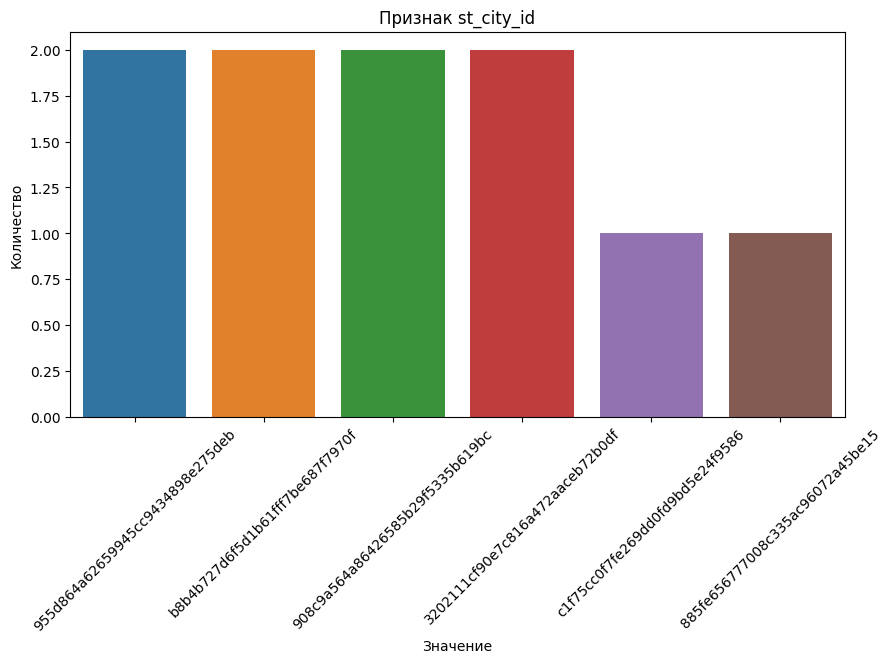


st_division_code
e26072c92d8fe0738df44d571d5f5e8b    2
da742b3cfca5388aaf9af28a726a3c30    2
429a86ff6336c144ddaf6144f52ab52c    2
296bd0cc6e735f9d7488ebc8fbc19130    2
32586311f16876abf92901085bd87b99    2
Name: st_division_code, dtype: int64


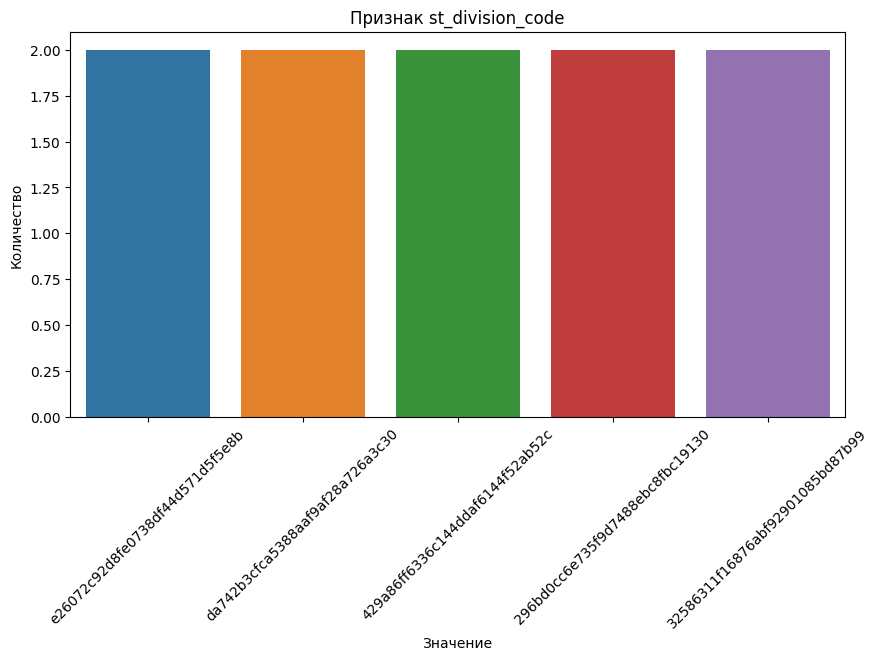


st_type_format_id
1    6
4    3
2    1
Name: st_type_format_id, dtype: int64


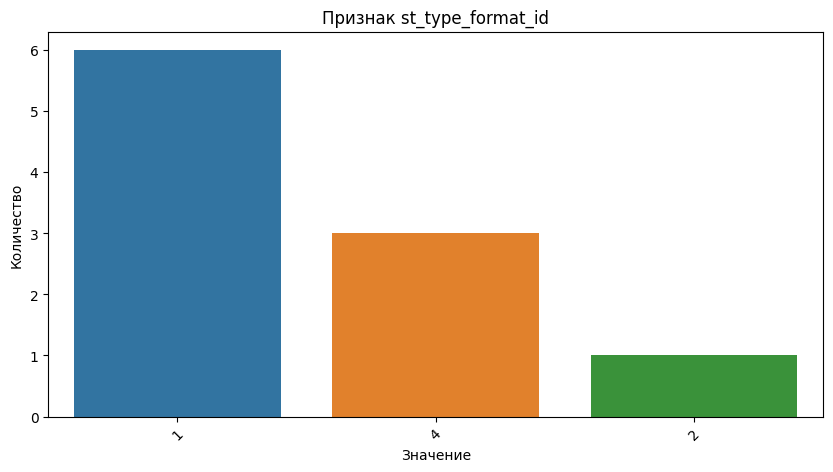


st_type_loc_id
1    6
3    3
2    1
Name: st_type_loc_id, dtype: int64


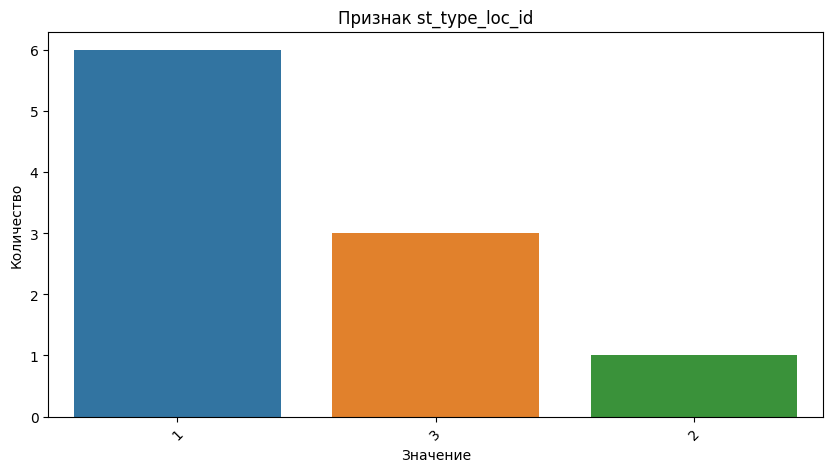


st_type_size_id
12    4
19    2
8     2
28    1
20    1
Name: st_type_size_id, dtype: int64


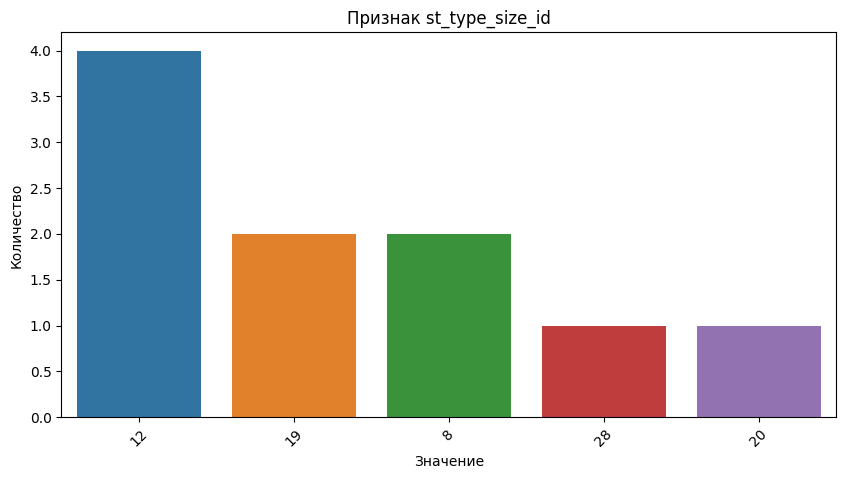

In [29]:
for column in df_st.columns:
    if column not in ['st_id', 'st_is_active']:
        print(column)
        print(df_st[column].value_counts())

        plt.xticks(rotation=45)
        sns.countplot(x=df_st[column],
                      order=df_st[column].value_counts().index).set(title=(f'Признак {column}'),
                                                xlabel='Значение',
                                                ylabel='Количество')
        plt.show()

        print('')

Отметим, неравномерную группировку магазинов по всем этим признакам, для дальнейшего обучения модели возможно использование этих признаков.

##### **Вывод**

1. Изучены данные датафрейма магазинов.
2. Магазины неравномерно распределены по различным категориям.

### Датафрейм категорий товаров

* pr_group_id – захэшированная группа товара;
* pr_cat_id – захэшированная категория товара;
* pr_subcat_id – захэшированная подкатегория товара;
* pr_sku_id – захэшированное id товара;
* pr_uom_id – маркер, обозначающий продаётся товар на вес или в шт.

In [30]:
df_pr.head()

,pr_sku_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
0,fd064933250b0bfe4f926b867b0a5ec8,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,17
1,71c9661741caf40a92a32d1cc8206c04,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17
2,00b72c2f01a1512cbb1d3f33319bac93,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,d407a3ebb4ab9b0d68b224486f8b8dad,17
3,9bc40cd2fe4f188f402bb41548c5e15c,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,17
4,3a74a370c8eb032acb11ad9119242b8f,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17


In [31]:
data_info = {
    'Уникальные значения': df_pr.nunique(),
    'Пропущенные значения': df_pr.isnull().sum(),
    'Тип': df_pr.dtypes
}

pd.DataFrame(data_info)

,Уникальные значения,Пропущенные значения,Тип
pr_sku_id,2050,0,object
pr_group_id,9,0,object
pr_cat_id,43,0,object
pr_subcat_id,170,0,object
pr_uom_id,2,0,int64


**Столбец pr_uom_id**

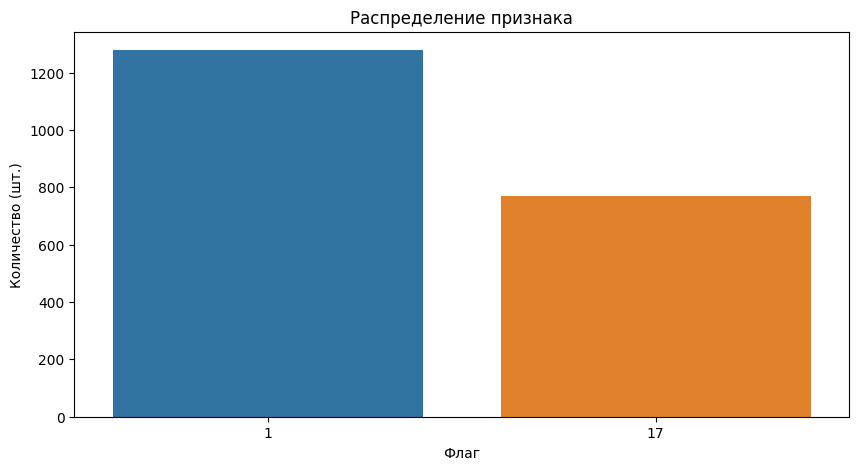

In [32]:
sns.countplot(x='pr_uom_id', data=df_pr)
plt.title('Распределение признака')
plt.xlabel('Флаг')
plt.ylabel('Количество (шт.)')

plt.show()

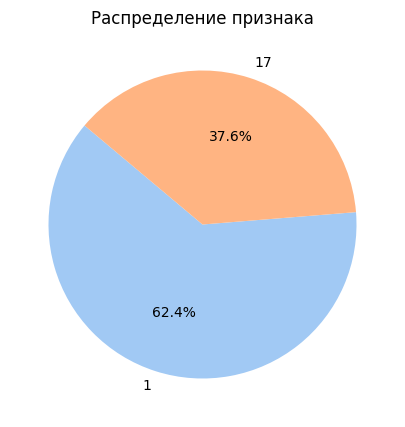

In [33]:
pr_uom_counts = df_pr['pr_uom_id'].value_counts()

colors = sns.color_palette('pastel')[0:2]

plt.pie(pr_uom_counts, labels=['1', '17'], autopct=lambda p: '{:.1f}%'.format(p), startangle=140, colors=colors)

plt.title('Распределение признака')

plt.show()

Видим, что значение 1 почти в два раз преобладает над значением 17.

**Остальные признаки**

pr_group_id
c74d97b01eae257e44aa9d5bade97baf    806
aab3238922bcc25a6f606eb525ffdc56    717
6512bd43d9caa6e02c990b0a82652dca    203
c51ce410c124a10e0db5e4b97fc2af39    182
c20ad4d76fe97759aa27a0c99bff6710     73
1ff1de774005f8da13f42943881c655f     37
32bb90e8976aab5298d5da10fe66f21d     27
98f13708210194c475687be6106a3b84      4
3c59dc048e8850243be8079a5c74d079      1
Name: pr_group_id, dtype: int64


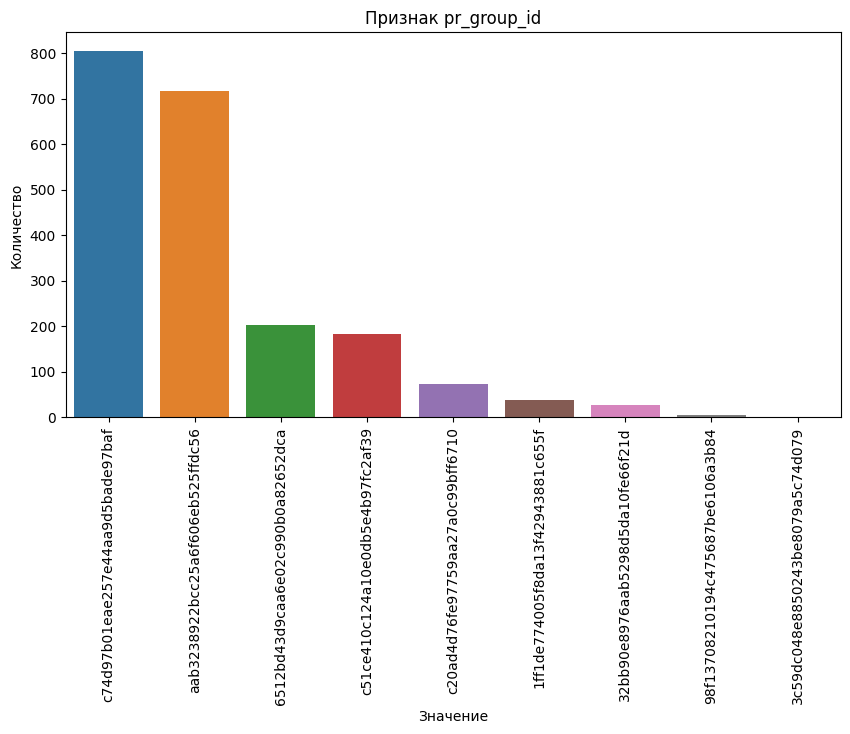


pr_cat_id
c559da2ba967eb820766939a658022c8    265
9701a1c165dd9420816bfec5edd6c2b1    222
1bc0249a6412ef49b07fe6f62e6dc8de    211
28fc2782ea7ef51c1104ccf7b9bea13d    167
46771d1f432b42343f56f791422a4991    112
f3173935ed8ac4bf073c1bcd63171f8a    111
e58cc5ca94270acaceed13bc82dfedf7     99
a368b0de8b91cfb3f91892fbf1ebd4b2     88
3de2334a314a7a72721f1f74a6cb4cee     79
fb2fcd534b0ff3bbed73cc51df620323     72
535ab76633d94208236a2e829ea6d888     61
b7087c1f4f89e63af8d46f3b20271153     43
7a6a74cbe87bc60030a4bd041dd47b78     42
b59c67bf196a4758191e42f76670ceba     39
a6ea8471c120fe8cc35a2954c9b9c595     37
faafda66202d234463057972460c04f5     33
c9f95a0a5af052bffce5c89917335f67     33
fd5c905bcd8c3348ad1b35d7231ee2b1     31
4edaa105d5f53590338791951e38c3ad     31
5caf41d62364d5b41a893adc1a9dd5d4     30
6d9c547cf146054a5a720606a7694467     25
186a157b2992e7daed3677ce8e9fe40f     25
a14ac55a4f27472c5d894ec1c3c743d2     21
f18a6d1cde4b205199de8729a6637b42     20
f9ab16852d455ce9203da64f4fc7f

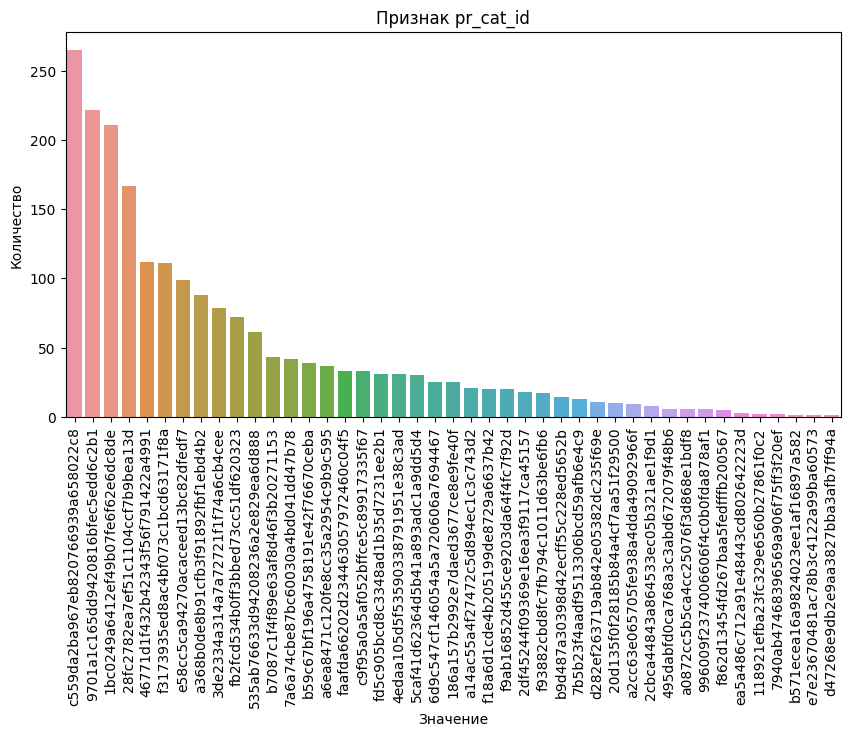


pr_subcat_id
8feef08314d477a5b68ba18a6d35819d    72
c01c475ac8d447730ece97d846cc4f25    60
0f3abfd67959c079e7b3759440e7415c    49
41b1d51c9e3ba9a263361f9cfa0eb434    48
c93c26cd49ea08e6b8984351d4164575    48
                                    ..
9d8f103e98545ee0e66801f0699110bf     1
858da246521bcdc8490ff01828e36f22     1
bb44cd485a19a2b227b3ccc473d10302     1
2a5b7197a4980fa272ebe4822ce9d95a     1
bd64a7fd410708f485412e9feabefde9     1
Name: pr_subcat_id, Length: 170, dtype: int64


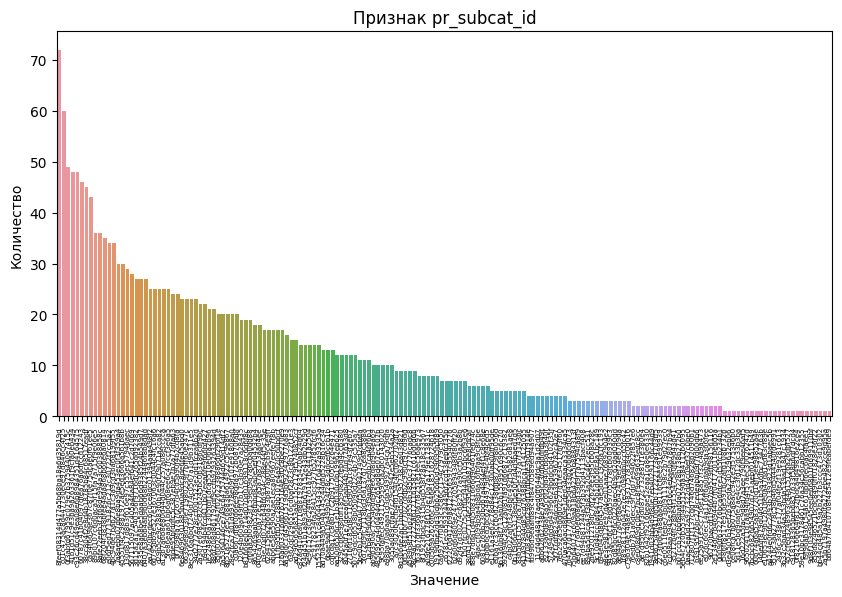

In [34]:
for column in df_pr.columns:
    if column not in ['pr_sku_id', 'pr_uom_id']:
        print(column)
        print(df_pr[column].value_counts())

        plt.xticks(rotation=90)
        if column == 'pr_subcat_id':
            plt.xticks(fontsize=5)
        sns.countplot(x=df_pr[column],
                      order=df_pr[column].value_counts().index).set(title=(f'Признак {column}'),
                                                xlabel='Значение',
                                                ylabel='Количество')
        plt.show()

        print('')

Видим очень неравномерное респределение продуктов внутри групп,категорий и подкатегорий.

Для топ 10 признаков построим распределения 1 и 17.

In [35]:
def plot_stacked_bar(column, title, n=None):

    top_categories = df_pr[column].value_counts().head(n).index
    data = df_pr[df_pr[column].isin(top_categories)]

    grouped = data.groupby([column, 'pr_uom_id']).size().unstack(fill_value=0)
    grouped_norm = grouped.div(grouped.sum(axis=1), axis=0)

    grouped_norm.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='viridis')

    plt.title(title)
    plt.xlabel(column)
    plt.ylabel('Соотношение')
    plt.xticks(rotation=45)
    plt.show()

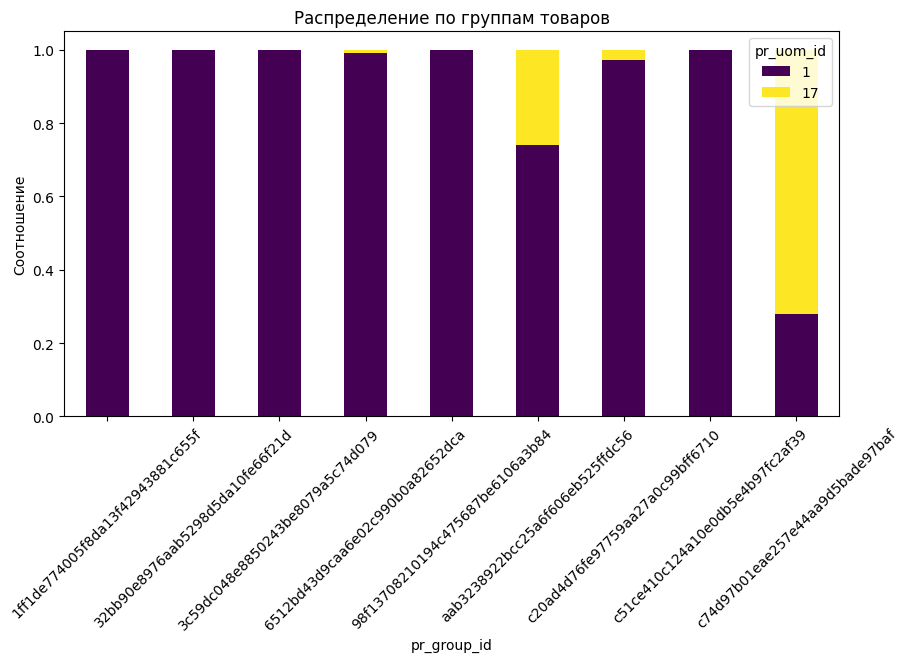

In [36]:
plot_stacked_bar('pr_group_id', 'Распределение по группам товаров', 10)

По группам видим, что для топ 10 в большинстве групп преобладает 1.

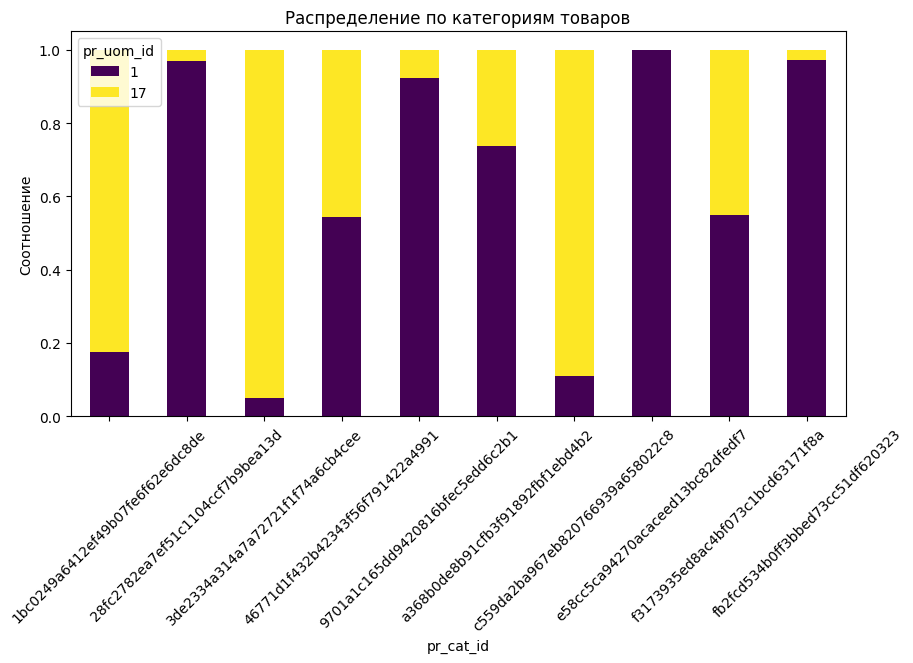

In [37]:
plot_stacked_bar('pr_cat_id', 'Распределение по категориям товаров', 10)

Для топ 10 категорий видим, что в некоторых катгеориях преобладает 1, в некоторых 17, в некоторых распределение флагов почти поровну.

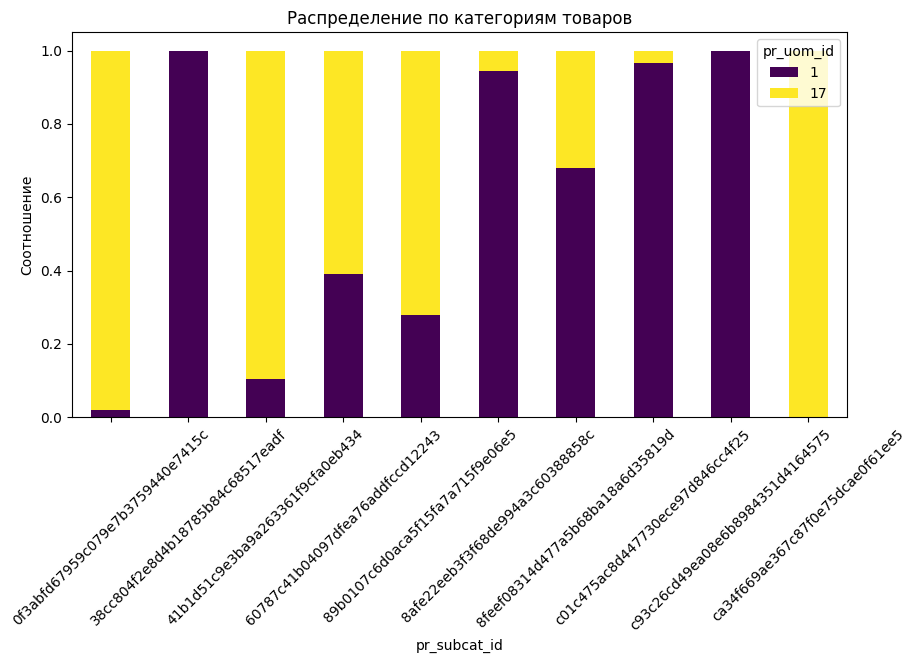

In [38]:
plot_stacked_bar('pr_subcat_id', 'Распределение по категориям товаров', 10)

Для субкатегорий аналогичная картина.

##### **Вывод**

1. Неравномерное распределение товаров по флагу продаж поштучно и по весу, разница почти в два раза.
2. Очень неравномерное распределение товаров по группам, категориям и подкатегориям. В некоторых 1 в некоторых несколько сотен.
3. Для распределение флага продаж по топ 10 групп, категорий, подкатегорий товаров также видим неравномерное распределение внутри групп, категорий и подкатегорий.

### Датафрейм продаж

In [39]:
df_sales.head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.000,5.000,825.000,825.000
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.000,0.000,196.000,0.000
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.000,0.000,78.000,0.000
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.000,0.000,69.000,69.000
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.000,0.000,161.000,0.000


In [40]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882286 entries, 0 to 882285
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   st_id                    882286 non-null  object        
 1   pr_sku_id                882286 non-null  object        
 2   date                     882286 non-null  datetime64[ns]
 3   pr_sales_type_id         882286 non-null  int64         
 4   pr_sales_in_units        882286 non-null  float64       
 5   pr_promo_sales_in_units  882286 non-null  float64       
 6   pr_sales_in_rub          882286 non-null  float64       
 7   pr_promo_sales_in_rub    882286 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 53.9+ MB


**Столбец даты**

In [41]:
display(df_sales['date'].sort_values().head())
display(df_sales['date'].sort_values().tail())

571118   2022-08-01
358409   2022-08-01
544705   2022-08-01
437386   2022-08-01
709331   2022-08-01
Name: date, dtype: datetime64[ns]

401616   2023-07-18
19744    2023-07-18
23076    2023-07-18
73974    2023-07-18
411160   2023-07-18
Name: date, dtype: datetime64[ns]

У нас есть данные от 01.08.22 до 18.07.23.

#### Анализ временного ряда

In [42]:
aggregated_sales = df_sales.groupby('date')['pr_sales_in_units'].sum().reset_index()
aggregated_sales.set_index('date', inplace=True)

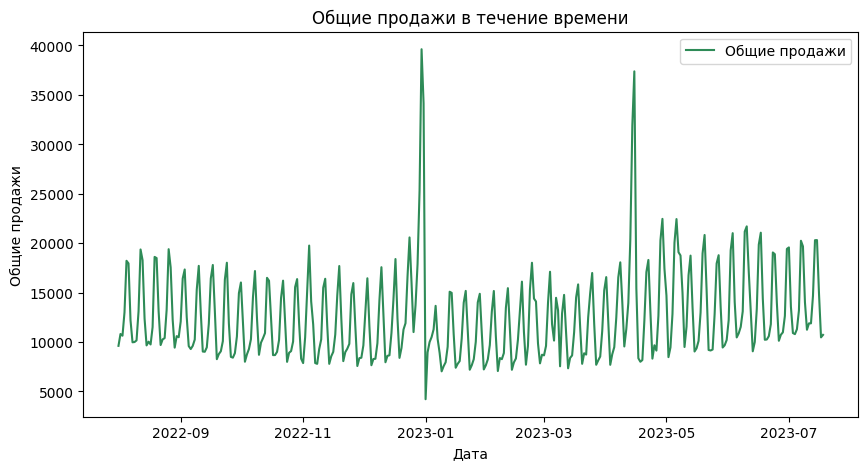

In [43]:
plt.plot(aggregated_sales.index, aggregated_sales.pr_sales_in_units, label='Общие продажи', color = 'seagreen')
plt.title('Общие продажи в течение времени')
plt.xlabel('Дата')
plt.ylabel('Общие продажи')
plt.legend(loc='best')

plt.show()

Наблюдаем ярко выраженные пики в конце декабря, со спадом в начале января и в середине апреля. Временной ряд похож на аддитивный.

Проведем сезонную декомпозицию.

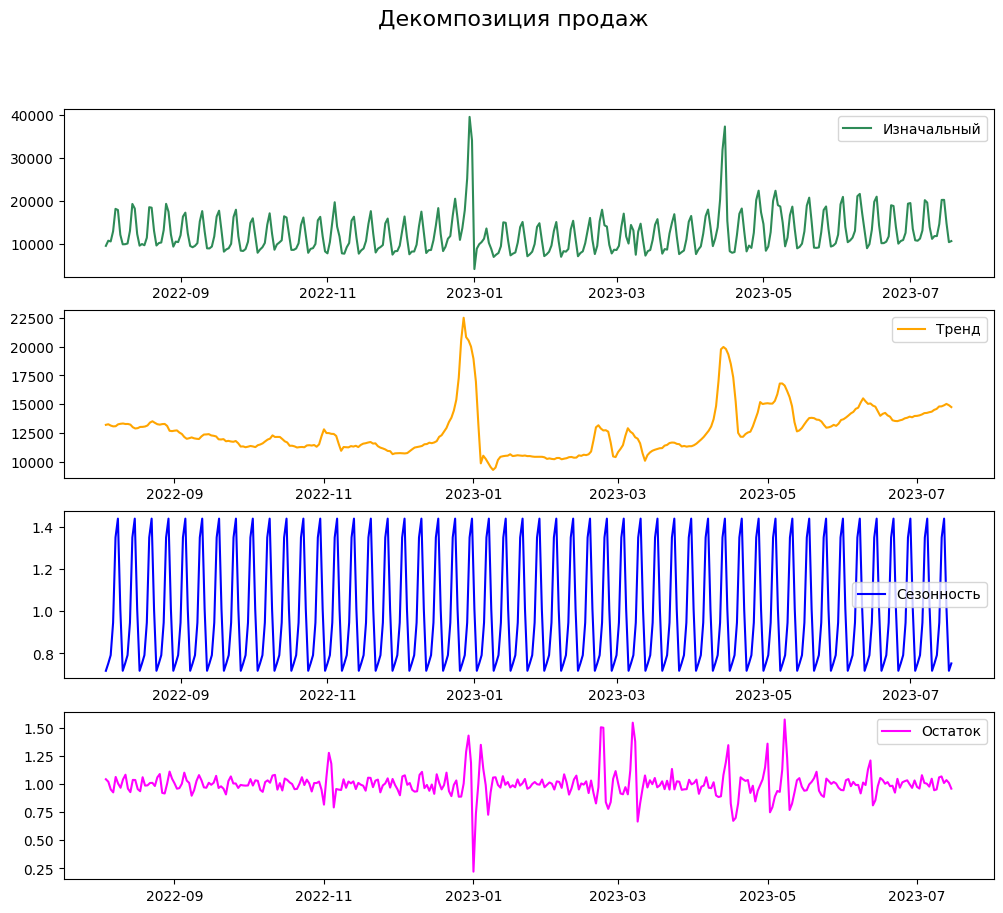

In [44]:
decomposition = seasonal_decompose(aggregated_sales, 'model=additive')
plt.figure(figsize=(12, 10))
plt.suptitle('Декомпозиция продаж', fontsize=16)

plt.subplot(411)
plt.plot(decomposition.observed, label='Изначальный', color = 'seagreen')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(decomposition.trend, label='Тренд', color = 'orange')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Сезонность', color = 'blue')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(decomposition.resid, label='Остаток', color = 'magenta')

plt.legend(loc='best')
plt.show()

В тренде видим снижение к концу года, резкий всплеск и снижении в течении декабря-января, потом тренд идет вверх до июля со скачком в апреле и в мае.

Видим явную сезонность. Рассмотрим график ближе, чтобы оперделить период.

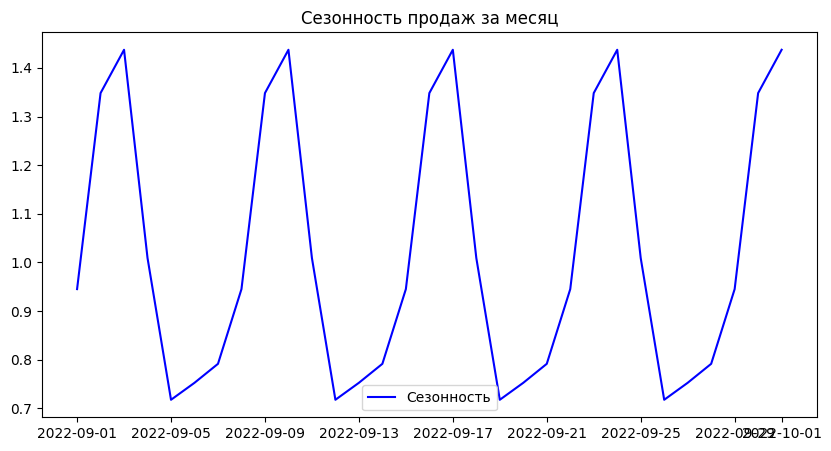

In [45]:
plt.title('Сезонность продаж за месяц');

plt.plot(decomposition.seasonal['2022-09-01':'2022-10-01'], label='Сезонность', color = 'blue')

plt.legend(loc='best')
plt.show()

Видим явную недельную сезонность.

Построим функцию автокорелляции.

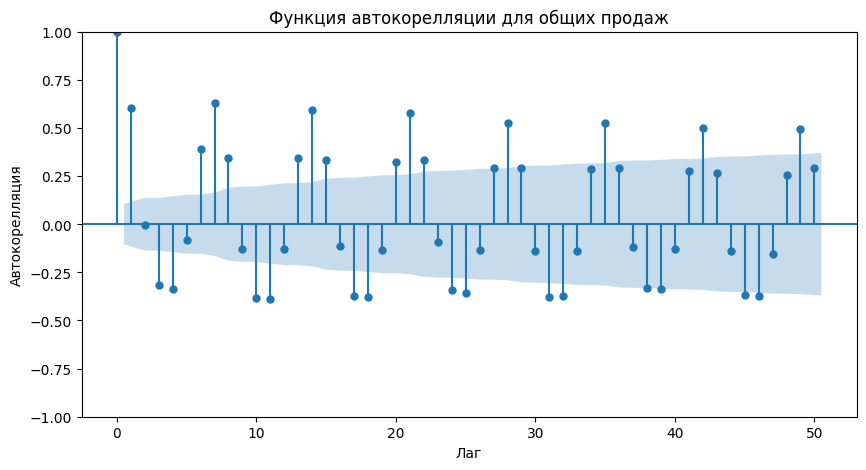

In [46]:
plot_acf(aggregated_sales, lags=50)

plt.title('Функция автокорелляции для общих продаж')
plt.xlabel('Лаг')
plt.ylabel('Автокорелляция')
plt.show()

Самые высокие пики помимо 0 для лагов 1 и 7.

Проверим стационарность временного ряда.

Построим график с rolling mean и rolling std.

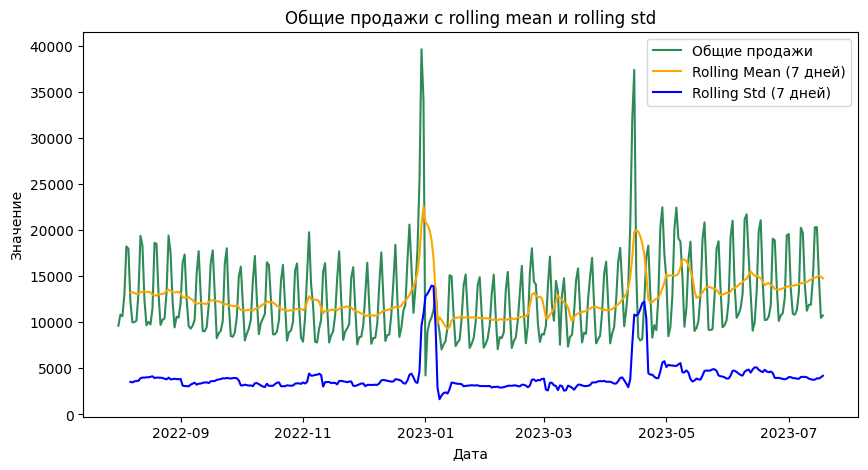

In [47]:
window = 7
aggregated_sales['rolling_mean'] = aggregated_sales['pr_sales_in_units'].rolling(window=window).mean()
aggregated_sales['rolling_std'] = aggregated_sales['pr_sales_in_units'].rolling(window=window).std()

plt.plot(aggregated_sales.index, aggregated_sales['pr_sales_in_units'], label='Общие продажи', color='seagreen')
plt.plot(aggregated_sales.index, aggregated_sales['rolling_mean'], label=f'Rolling Mean ({window} дней)', color='orange')
plt.plot(aggregated_sales.index, aggregated_sales['rolling_std'], label=f'Rolling Std ({window} дней)', color='blue')

plt.title('Общие продажи с rolling mean и rolling std')
plt.xlabel('Дата')
plt.ylabel('Значение')

plt.legend(loc='best')
plt.show()

Rolling mean и rolling standard имеют вариативность и тренды. Возможно временной ряд нестационарен. Проведем дополнительные тесты.

**Тест ADF.**

In [48]:
adf = adfuller(aggregated_sales['pr_sales_in_units'])

p_value = round(adf[1], 3)

print('p_value', p_value)

p_value 0.015


Примем уровень значимости 0.05

p_value меньше уровня значимости, отвергаем нулевую гипотезу, согласно тесту временной ряд стационарен.

Тест KPSS.

In [49]:
kpss_r = kpss(aggregated_sales['pr_sales_in_units'])

p_value = round(kpss_r[1], 3)

print('p_value', p_value)

p_value 0.011


p_value меньше уровня значимости, отвергаем нулевую гипотезу (для KPSS это то, что временной ряд стационарен), согласно тесту временной ряд нестационарен.

Мы не можем точно определить стационарен ли временной ряд тест ADF и тест KPSS противоречат друг другу. Нам будет нуно учитывать это при построении модели.

##### **Вывод**

1. Представлены данные с 01.08.22 до 18.07.23.
2. Имеются ярко выраженные пики в конце декабря, со спадом в начале января и в середине апреля. Временной ряд похож на аддитивный.
3. Проведена декомпозиция. В тренде видим снижение к концу года, резкий всплеск и снижении в течении декабря-января, потом тренд идет вверх до июля со скачком в апреле и в мае. Видна явная недельная сезонность.
4. По функции автокорелляции наиболее важные лаги 1 и 7 дней.
5. Не можем точно определить стационарность ряда из-за противоречия тестов ADF и KPSS.

#### Проверка на аномалии

Для начала построим boxplot.

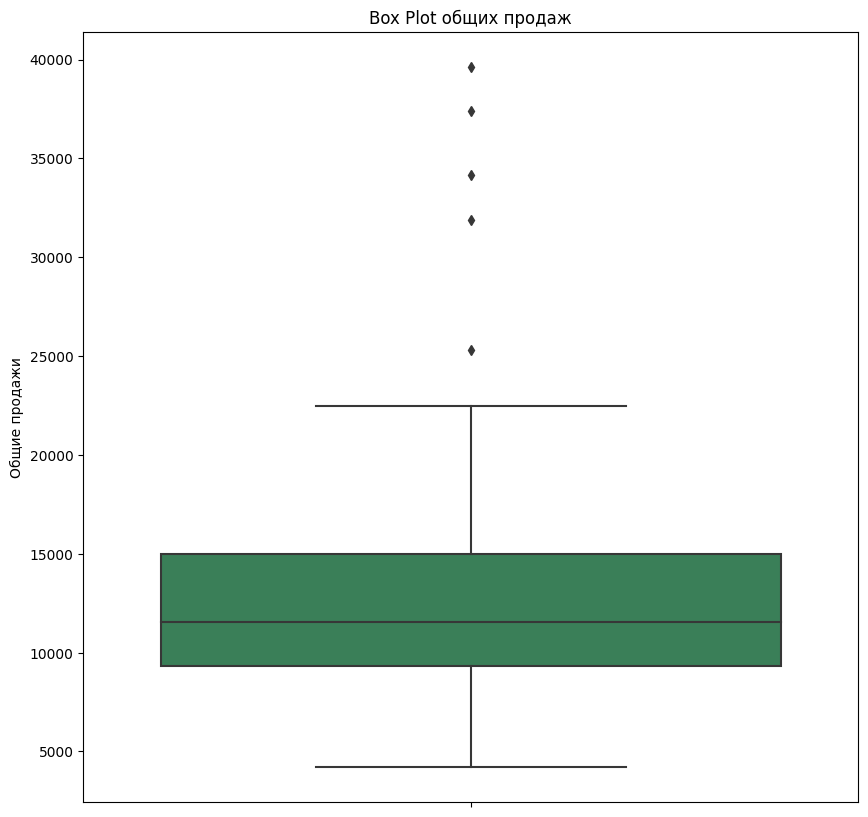

In [50]:
plt.figure(figsize=(10, 10))

sns.boxplot(y=aggregated_sales['pr_sales_in_units'], color='seagreen')
plt.title('Box Plot общих продаж')
plt.ylabel('Общие продажи')

plt.show()

На графике видны выбросы.

Проведем дополнительные тесты.

**zcore и IQR**

In [51]:
aggregated_sales['z_score'] = zscore(aggregated_sales['pr_sales_in_units'])

outliers_z_score = aggregated_sales[np.abs(aggregated_sales['z_score']) > 3]

outliers_z_score

,pr_sales_in_units,rolling_mean,rolling_std,z_score
date,,,,
2022-12-30,39616.000,20586.286,9587.830,5.935
2022-12-31,34153.000,22526.000,10872.573,4.734
2023-04-14,31897.000,17019.000,7535.188,4.237
2023-04-15,37377.000,19779.429,10806.723,5.443


In [52]:
q1 = aggregated_sales['pr_sales_in_units'].quantile(0.25)
q3 = aggregated_sales['pr_sales_in_units'].quantile(0.75)

iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers_iqr = aggregated_sales[(aggregated_sales['pr_sales_in_units'] < lower_bound) |
                                (aggregated_sales['pr_sales_in_units'] > upper_bound)]

outliers_iqr

,pr_sales_in_units,rolling_mean,rolling_std,z_score
date,,,,
2022-12-29,25302.000,17299.857,4648.073,2.787
2022-12-30,39616.000,20586.286,9587.830,5.935
2022-12-31,34153.000,22526.000,10872.573,4.734
2023-04-14,31897.000,17019.000,7535.188,4.237
2023-04-15,37377.000,19779.429,10806.723,5.443


Тесты нашли аномальные значения для 29, 30, 31 января и 14, 15 апреля. Аномальные значения для декабря объясняются близостью Нового Года. Аномальные значения в апреле требуют дополнительного анализа.

In [53]:
december_dates = pd.date_range(start='2022-12-25', end='2023-01-05')
april_dates = pd.date_range(start='2023-04-10', end='2023-04-20')

december_sales = df_sales[df_sales['date'].isin(december_dates)]
april_sales = df_sales[df_sales['date'].isin(april_dates)]

december_sales_aggregated = december_sales.groupby(['date', 'pr_sku_id']).agg(
    total_sales_units=pd.NamedAgg(column='pr_sales_in_units', aggfunc='sum'),
    promo_sales_units=pd.NamedAgg(column='pr_promo_sales_in_units', aggfunc='sum'),
    total_sales_rub=pd.NamedAgg(column='pr_sales_in_rub', aggfunc='sum'),
    promo_sales_rub=pd.NamedAgg(column='pr_promo_sales_in_rub', aggfunc='sum')
).reset_index()

april_sales_aggregated = april_sales.groupby(['date', 'pr_sku_id']).agg(
    total_sales_units=pd.NamedAgg(column='pr_sales_in_units', aggfunc='sum'),
    promo_sales_units=pd.NamedAgg(column='pr_promo_sales_in_units', aggfunc='sum'),
    total_sales_rub=pd.NamedAgg(column='pr_sales_in_rub', aggfunc='sum'),
    promo_sales_rub=pd.NamedAgg(column='pr_promo_sales_in_rub', aggfunc='sum')
).reset_index()

display(december_sales_aggregated.head())
display(april_sales_aggregated.head())

,date,pr_sku_id,total_sales_units,promo_sales_units,total_sales_rub,promo_sales_rub
0,2022-12-25,00661699f543753ec7e911a64b9fd2f6,10.000,7.000,2581.000,1640.000
1,2022-12-25,0094042bfeae507dc7f62acc8e5ed03a,15.000,4.000,2888.000,626.000
2,2022-12-25,00b72c2f01a1512cbb1d3f33319bac93,3.000,2.000,44.000,28.000
3,2022-12-25,00d9e3b6725a72b3235a048868691e09,3.000,0.000,245.000,0.000
4,2022-12-25,011fa371d88bc0c9c45f7a03db82d5b7,1.000,1.000,77.000,77.000


,date,pr_sku_id,total_sales_units,promo_sales_units,total_sales_rub,promo_sales_rub
0,2023-04-10,00661699f543753ec7e911a64b9fd2f6,9.000,0.000,2358.000,0.000
1,2023-04-10,0094042bfeae507dc7f62acc8e5ed03a,16.000,9.000,3062.000,1494.000
2,2023-04-10,00b72c2f01a1512cbb1d3f33319bac93,5.000,1.000,118.000,16.000
3,2023-04-10,00f48855a138893e462696650a2375d9,1.000,0.000,30.000,0.000
4,2023-04-10,011fa371d88bc0c9c45f7a03db82d5b7,1.000,0.000,130.000,0.000


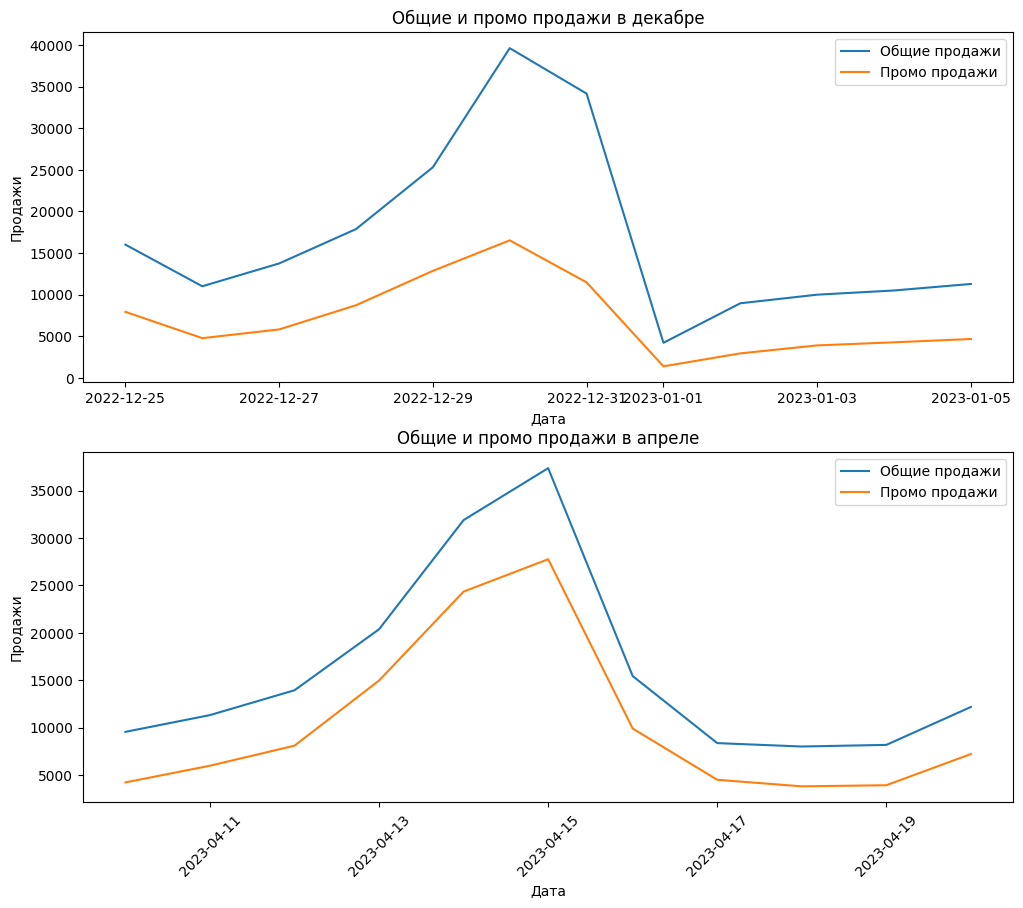

In [54]:
december_sales_date = december_sales_aggregated.groupby('date').agg(
    total_sales_units=pd.NamedAgg(column='total_sales_units', aggfunc='sum'),
    promo_sales_units=pd.NamedAgg(column='promo_sales_units', aggfunc='sum'),
    total_sales_rub=pd.NamedAgg(column='total_sales_rub', aggfunc='sum'),
    promo_sales_rub=pd.NamedAgg(column='promo_sales_rub', aggfunc='sum')
).reset_index()

april_sales_date = april_sales_aggregated.groupby('date').agg(
    total_sales_units=pd.NamedAgg(column='total_sales_units', aggfunc='sum'),
    promo_sales_units=pd.NamedAgg(column='promo_sales_units', aggfunc='sum'),
    total_sales_rub=pd.NamedAgg(column='total_sales_rub', aggfunc='sum'),
    promo_sales_rub=pd.NamedAgg(column='promo_sales_rub', aggfunc='sum')
).reset_index()

fig, axes = plt.subplots(2, 1, figsize=(12, 10))
sns.lineplot(x='date', y='total_sales_units', data=december_sales_date, ax=axes[0], label='Общие продажи')
sns.lineplot(x='date', y='promo_sales_units', data=december_sales_date, ax=axes[0], label='Промо продажи')
axes[0].set_title('Общие и промо продажи в декабре')
axes[0].set_ylabel('Продажи')
axes[0].set_xlabel('Дата')
axes[0].legend()

sns.lineplot(x='date', y='total_sales_units', data=april_sales_date, ax=axes[1], label='Общие продажи')
sns.lineplot(x='date', y='promo_sales_units', data=april_sales_date, ax=axes[1], label='Промо продажи')
axes[1].set_title('Общие и промо продажи в апреле')
axes[1].set_ylabel('Продажи')
axes[1].set_xlabel('Дата')
axes[1].legend()

plt.xticks(rotation=45)
plt.show()

Видим, что для апреля промо продажи составляют большую часть от общих продаж.

Посмотрим на продажи промо и не промо товаров.

In [55]:
def promotions_and_sales_types(sales_data):
    promotion_analysis = sales_data.groupby(['date', 'pr_sales_type_id']).agg(
        total_sales_units=pd.NamedAgg(column='pr_sales_in_units', aggfunc='sum'),
        promo_sales_units=pd.NamedAgg(column='pr_promo_sales_in_units', aggfunc='sum'),
        total_sales_rub=pd.NamedAgg(column='pr_sales_in_rub', aggfunc='sum'),
        promo_sales_rub=pd.NamedAgg(column='pr_promo_sales_in_rub', aggfunc='sum')
    ).reset_index()
    return promotion_analysis

december_promotion_analysis = promotions_and_sales_types(december_sales)
april_promotion_analysis = promotions_and_sales_types(april_sales)

display(december_promotion_analysis.head())
display(april_promotion_analysis.head())

,date,pr_sales_type_id,total_sales_units,promo_sales_units,total_sales_rub,promo_sales_rub
0,2022-12-25,0,8079.000,0.000,837846.000,0.000
1,2022-12-25,1,7922.000,7922.000,1488185.000,1488185.000
2,2022-12-26,0,6235.000,0.000,724135.000,0.000
3,2022-12-26,1,4763.000,4763.000,811850.000,811850.000
4,2022-12-27,0,7930.000,0.000,922198.000,0.000


,date,pr_sales_type_id,total_sales_units,promo_sales_units,total_sales_rub,promo_sales_rub
0,2023-04-10,0,5336.000,0.000,560014.000,0.000
1,2023-04-10,1,4206.000,4206.000,457535.000,457535.000
2,2023-04-11,0,5344.000,0.000,574483.000,0.000
3,2023-04-11,1,5967.000,5967.000,552357.000,552357.000
4,2023-04-12,0,5850.000,0.000,639877.000,0.000


In [56]:
def plot_promotion(promotion, title):

    plt.figure(figsize=(12, 6))
    ax = sns.lineplot(x='date', y='total_sales_units', hue='pr_sales_type_id', data=promotion,
                      palette='viridis', style='pr_sales_type_id', markers=True, dashes=False)
    plt.title(title)
    plt.ylabel('Продажи')
    plt.xlabel('Дата')

    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles=handles[:], labels=['Без промо', 'С промо'], title='Флаг промо')

    plt.xticks(rotation=45)
    plt.show()

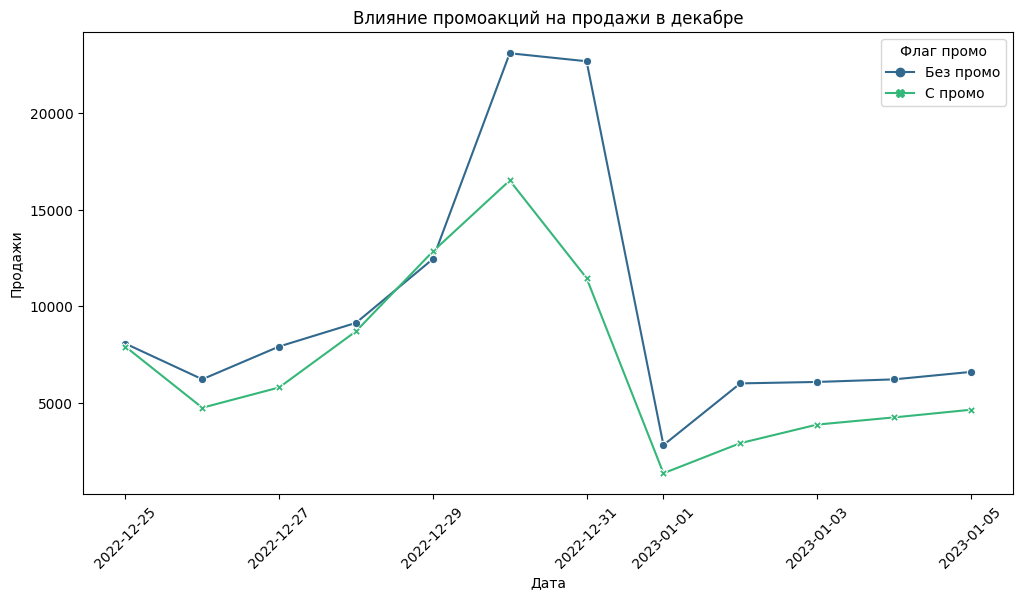

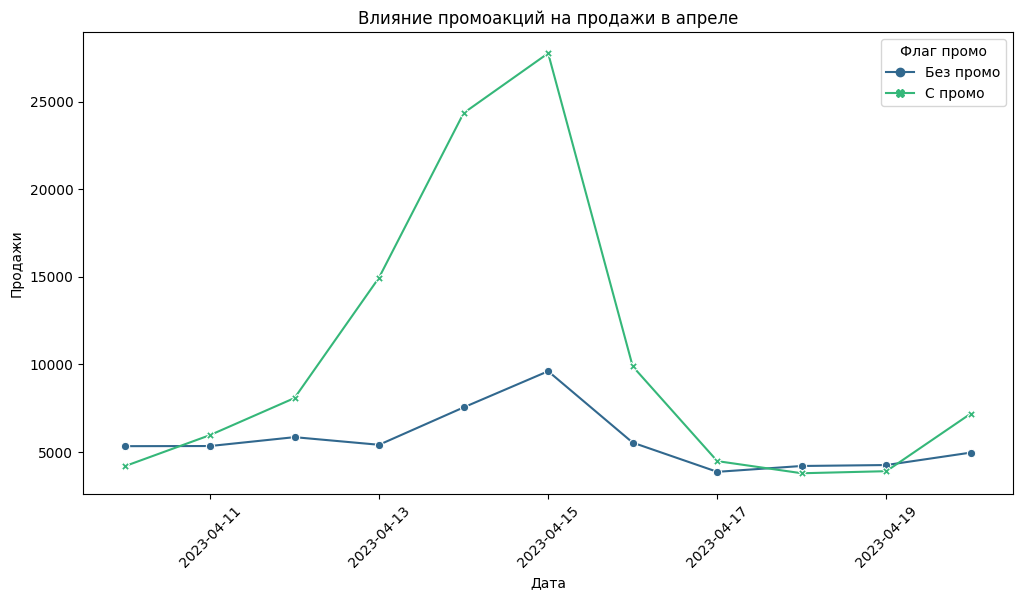

In [57]:
plot_promotion(december_promotion_analysis, 'Влияние промоакций на продажи в декабре')
plot_promotion(april_promotion_analysis, 'Влияние промоакций на продажи в апреле')

Видим, что большая часть продаж в апреле была с промо, а для декабря без промо.

##### **Вывод**

1. Найдены аномалии графическим и тестовыми методами.
2. Аномалии исследованы:
    * Аномалии в декабре обусловлены закупками перед Новым Годом;
    * Аномалии в апреле обусловлены промоакциями.
3. Такие аномалии следует учесть при обучении модели.

#### Исследование продаж.

Построим общие продажи и отметим те, которые выши медианы зеленым цветом, а те которые ниже красным.

In [58]:
median_sales = aggregated_sales['pr_sales_in_units'].median()
aggregated_sales['above_median'] = aggregated_sales['pr_sales_in_units'] > median_sales
first_days_of_month = aggregated_sales.resample('MS').first().index

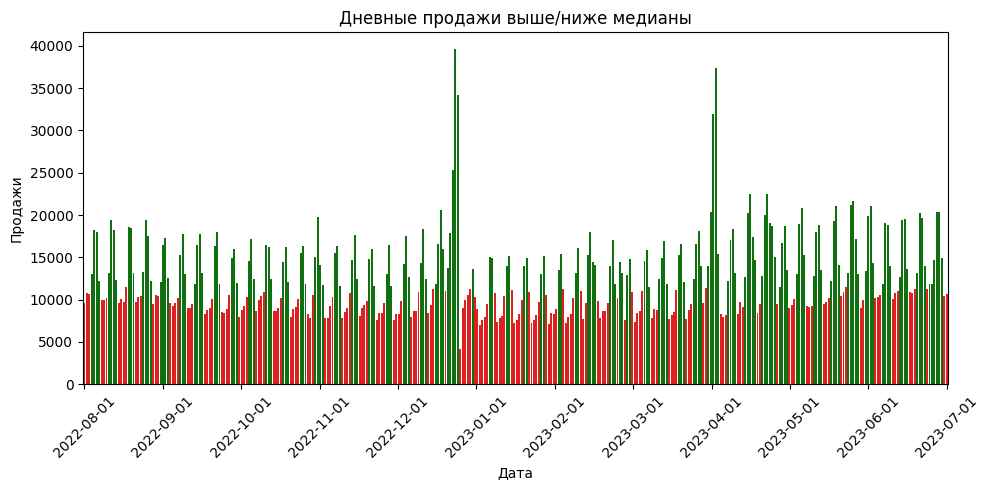

In [59]:
sns.barplot(x=aggregated_sales.index, y=aggregated_sales['pr_sales_in_units'],
            palette=aggregated_sales['above_median'].map({True: 'g', False: 'r'}))

plt.xticks(ticks=np.linspace(0, len(aggregated_sales)-1, len(first_days_of_month)),
           labels=first_days_of_month.strftime('%Y-%m-%d'), rotation=45)

plt.title('Дневные продажи выше/ниже медианы')
plt.xlabel('Дата')
plt.ylabel('Продажи')
plt.tight_layout()
plt.show()

Видим те же скачки в декабре и апреле, а так же то, что значения выше/ниже чередуются.

**Посмотрим по месяцам.**

Добавим столбец месяц.

In [60]:
aggregated_sales['month'] = aggregated_sales.index.to_period('M')

In [61]:
print(aggregated_sales['month'].head())
print(aggregated_sales['month'].tail())

date
2022-08-01    2022-08
2022-08-02    2022-08
2022-08-03    2022-08
2022-08-04    2022-08
2022-08-05    2022-08
Name: month, dtype: period[M]
date
2023-07-14    2023-07
2023-07-15    2023-07
2023-07-16    2023-07
2023-07-17    2023-07
2023-07-18    2023-07
Name: month, dtype: period[M]


In [62]:
monthly_aggregated_sales = aggregated_sales.groupby('month')['pr_sales_in_units'].sum().reset_index()
monthly_median_sales = monthly_aggregated_sales['pr_sales_in_units'].median()
monthly_aggregated_sales['above_median'] = monthly_aggregated_sales['pr_sales_in_units'] > monthly_median_sales

In [63]:
month_to_replace = {
    'January': 'Январь',
    'February': 'Февраль',
    'March': 'Март',
    'April': 'Апрель',
    'May': 'Май',
    'June': 'Июнь',
    'July': 'Июля',
    'August': 'Август',
    'September': 'Сентябрь',
    'October': 'Октябрь',
    'November': 'Ноябрь',
    'December': 'Декабрь'
}

In [64]:
def replace_month(s, replacements):

    for key, value in replacements.items():
        s = s.replace(key, value)
    return s

In [65]:
plot_month_sales = monthly_aggregated_sales['month'].dt.strftime('%B %Y')
plot_month_sales = plot_month_sales.apply(replace_month, replacements=month_to_replace)

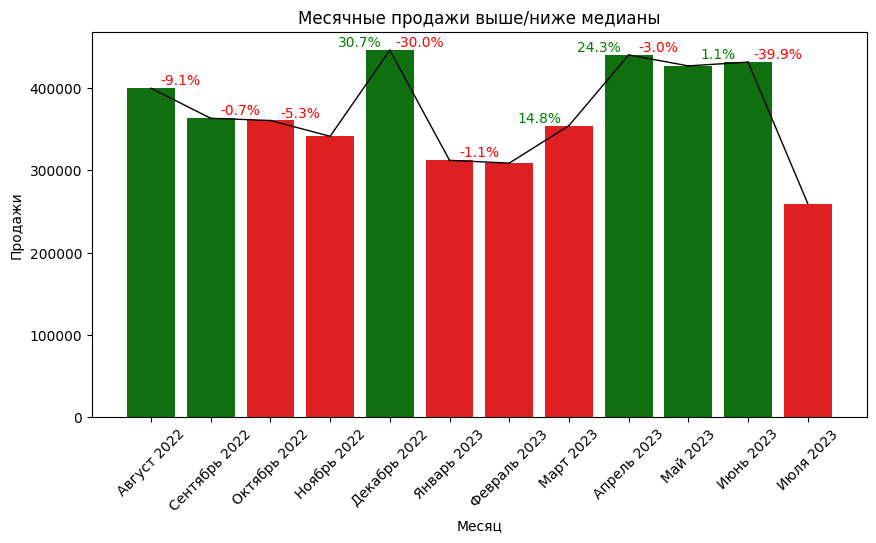

In [66]:
bar_plot = sns.barplot(x=plot_month_sales,
                       y=monthly_aggregated_sales['pr_sales_in_units'],
                       palette=monthly_aggregated_sales['above_median'].map({True: 'g', False: 'r'}))
plt.title('Месячные продажи выше/ниже медианы')
plt.xlabel('Месяц')
plt.ylabel('Продажи')
plt.xticks(rotation=45)

for i in range(1, len(monthly_aggregated_sales)):
    change = ((monthly_aggregated_sales.loc[i, 'pr_sales_in_units'] -
               monthly_aggregated_sales.loc[i - 1, 'pr_sales_in_units']) /
               monthly_aggregated_sales.loc[i - 1, 'pr_sales_in_units']) * 100
    color = 'g' if change >= 0 else 'r'
    x = [i - 1, i]
    y = [monthly_aggregated_sales.loc[i - 1, 'pr_sales_in_units'], monthly_aggregated_sales.loc[i, 'pr_sales_in_units']]
    label_y = max(y) + (0.02 * max(monthly_aggregated_sales['pr_sales_in_units']))
    plt.plot(x, y, color='k', linestyle='-', linewidth=1)
    plt.text(np.mean(x), label_y, f'{change:.1f}%', color=color, ha='center', va='center')

plt.show()

Самые высокие продажи в декабре и апреле. Ещё раз отметим тренд на снижения с августа до декабря, подъем в декабре, упадок до февраля, рост весной и снижение к июлю.

**Посмотрим по дням недели**

In [67]:
aggregated_sales = aggregated_sales.drop(columns=['day_of_week'], errors='ignore')

aggregated_sales['day_of_week'] = aggregated_sales.index.dayofweek + 1

In [68]:
daily_aggregated_sales = aggregated_sales.groupby('day_of_week')['pr_sales_in_units'].sum().reset_index()

day_name_mapping = {1: 'Понедельник', 2: 'Вторник', 3: 'Среда', 4: 'Четверг', 5: 'Пятница', 6: 'Суббота', 7: 'Воскресенье'}
daily_aggregated_sales['day_of_week'] = daily_aggregated_sales['day_of_week'].map(day_name_mapping)

order_of_days = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
daily_aggregated_sales['day_of_week'] = pd.Categorical(daily_aggregated_sales['day_of_week'], categories=order_of_days, ordered=True)
daily_aggregated_sales.sort_values('day_of_week', inplace=True)

daily_median_sales = daily_aggregated_sales['pr_sales_in_units'].median()
daily_aggregated_sales['above_median'] = daily_aggregated_sales['pr_sales_in_units'] > daily_median_sales

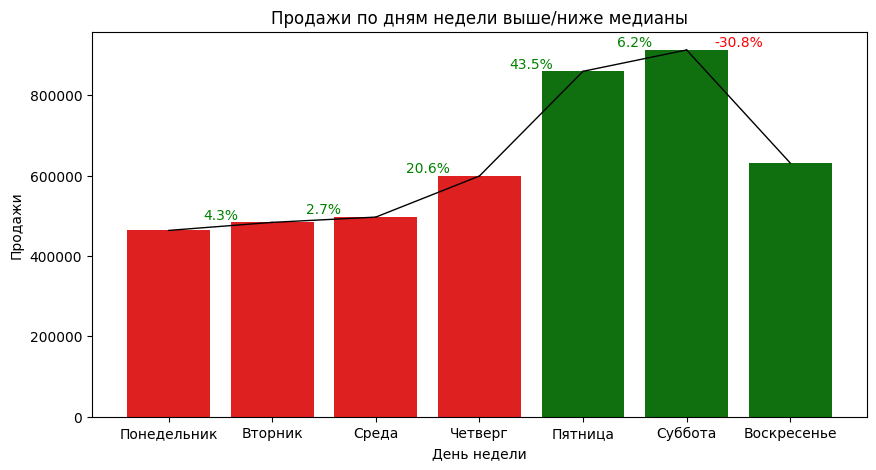

In [69]:
bar_plot = sns.barplot(x=daily_aggregated_sales['day_of_week'], y=daily_aggregated_sales['pr_sales_in_units'],
                       palette=daily_aggregated_sales['above_median'].map({True: 'g', False: 'r'}))
plt.title('Продажи по дням недели выше/ниже медианы')
plt.xlabel('День недели')
plt.ylabel('Продажи')

for i in range(len(daily_aggregated_sales)-1):
    x = [i, i + 1]
    y = [daily_aggregated_sales.loc[i, 'pr_sales_in_units'], daily_aggregated_sales.loc[i + 1, 'pr_sales_in_units']]

    change = ((y[1] - y[0]) / y[0]) * 100
    color = 'g' if change >= 0 else 'r'

    label_y = max(y) + (0.02 * max(daily_aggregated_sales['pr_sales_in_units']))

    plt.plot(x, y, color='k', linestyle='-', linewidth=1)

    plt.text(np.mean(x), label_y, f'{change:.1f}%', color=color, ha='center', va='center')

plt.show()

Отметим явный тренд на возрастание с понедельника, максимальное значение в субботу и снижение к воскресенью.

**Посмотрим по сезонам**

In [70]:
season_mapping = {
    12: 'Зима', 1: 'Зима', 2: 'Зима',
    3: 'Весна', 4: 'Весна', 5: 'Весна',
    6: 'Лето', 7: 'Лето', 8: 'Лето',
    9: 'Осень', 10: 'Осень', 11: 'Осень'
}

In [71]:
aggregated_sales['month_for_season'] = aggregated_sales.index.month
aggregated_sales['season'] = aggregated_sales['month_for_season'].map(season_mapping)

In [72]:
monthly_aggregated_sales = aggregated_sales.groupby('month')['pr_sales_in_units'].sum().reset_index()
monthly_median_sales = monthly_aggregated_sales['pr_sales_in_units'].median()
monthly_aggregated_sales['above_median'] = monthly_aggregated_sales['pr_sales_in_units'] > monthly_median_sales

In [73]:
season_aggregated_sales = aggregated_sales.groupby('season')['pr_sales_in_units'].sum().reset_index()
season_median_sales = season_aggregated_sales['pr_sales_in_units'].median()
season_aggregated_sales['above_median'] = season_aggregated_sales['pr_sales_in_units'] > season_median_sales

season_aggregated_sales

,season,pr_sales_in_units,above_median
0,Весна,1222210.000,True
1,Зима,1067293.000,False
2,Лето,1091246.000,True
3,Осень,1065558.000,False


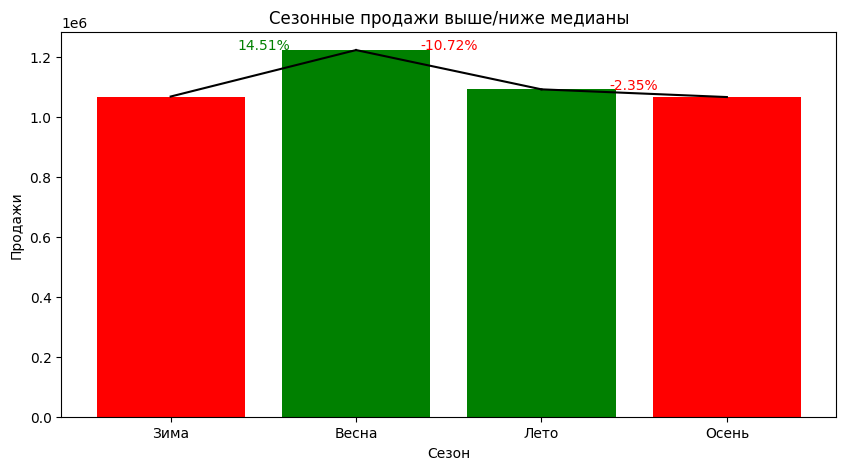

In [74]:
season_order = ['Зима', 'Весна', 'Лето', 'Осень']
season_aggregated_sales['season'] = pd.Categorical(season_aggregated_sales['season'], categories=season_order, ordered=True)
season_aggregated_sales = season_aggregated_sales.sort_values('season')

bar_colors = ['g' if above else 'r' for above in season_aggregated_sales['above_median']]

bars = plt.bar(season_aggregated_sales['season'], season_aggregated_sales['pr_sales_in_units'], color=bar_colors)

for i in range(1, len(bars)):
    x1, y1 = bars[i-1].get_x() + bars[i-1].get_width() / 2, bars[i-1].get_height()
    x2, y2 = bars[i].get_x() + bars[i].get_width() / 2, bars[i].get_height()

    plt.plot([x1, x2], [y1, y2], color='k')

    change = (y2 - y1) / y1 * 100
    color = 'g' if change > 0 else 'r'
    plt.annotate(f"{change:.2f}%", ((x1 + x2) / 2, max(y1, y2) + 0.02 * aggregated_sales['pr_sales_in_units'].max()),
                 color=color, ha='center')

plt.title('Сезонные продажи выше/ниже медианы')
plt.xlabel('Сезон')
plt.ylabel('Продажи')

plt.show()

Максимальные продажи весной и летом.

##### **Вывод**

1. В декабре и апреле скачки продаж выше медианных.
2. Самые высокие продажи в декабре и апреле. Есть тренд на снижение с августа до декабря, подъем в декабре, упадок до февраля, рост весной и снижение к июлю.
3. По дням явный тренд на возрастание с понедельника, максимальное значение в субботу и снижение к воскресенью.
4. По сезонам максимальные продажи весной и летом.
5. При обучении модели стоит учитывать эти зависимости.


## Вывод

1. Данные загружены и изучены.
2. Выполнена предобработка данных.
3. Выполнен анализ данных.
    1. В датафрейме магазинов присутствует неравномерное распределение данных магазинов внутри категорий и возможность использования этих признаков при обучении модели.
    2. В датафрейме категорий товаров также присутствует неравномерное распределение признаков, как флага продаж поштучно/повесу, так и категорий магазинов. Также внутри категорий флаг продаж также распространен неравномерно и сильно зависит от категории. Данные можно использовать для обучения в случае кластеризации.
    3. Датафрейм продаж.
        1. Проведен анализ временного ряда:
            * Выявлены пики в конце декабря и середине апреля;
            * Ряд аддитивный;
            * Проведена декомпозиция, явный тренд по месяцам и сезонность по неделям;
            * Наиболее важные лаги 1 и 7 дней;
            * Стационарность ряда определить с уверенностью не удалось.
        2. Проведена проверка на аномалии:
            * Аномалии определены графически и тестами;
            * Аномалии в конце декабря и в середине апреля;
            * Аномалии в декабре обусловлены закупками перед Новым Годом, аномалии в апреле обусловлены промоакциями.
        3. Проведено исследование продаж:
            * В декабре и апреле скачки продаж выше медианных.
            * Самые высокие продажи в декабре и апреле. Есть тренд на снижение с августа до декабря, подъем в декабре, упадок до февраля, рост весной и снижение к июлю.
            * По дням явный тренд на возрастание с понедельника, максимальное значение в субботу и снижение к воскресенью.
            * По сезонам максимальные продажи весной и летом.